In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from scipy.sparse import csr_matrix


import mongodb as md

import warnings; warnings.simplefilter('ignore')
movies = pd.read_csv("movies_metadata.csv")
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
movies = movies.drop([19730, 29503, 35587])
movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


small_links = pd.read_csv("small_links.csv")
ratings = pd.read_csv("ratings_small.csv")
movies = movies.rename(columns={'id':'movieId'})
movies["movieId"] = movies["movieId"].astype("int")

In [2]:
knn_ratings = ratings[["userId","movieId","rating"]]
knn_movies = movies[["movieId","title"]]
knn_movie_ratings = pd.merge(knn_movies,knn_ratings,on="movieId")

movie_rating_count = (knn_movie_ratings.
                      groupby(by=["title"])["rating"].
                      count().reset_index().
                      rename(columns={'rating':'totalRating'})
                      [["title","totalRating"]]
                     )
rating_with_totalRatingCount=knn_movie_ratings.merge(movie_rating_count,left_on='title',right_on='title',how="inner")

popularity_threshold=70
rating_popular_movie=rating_with_totalRatingCount[rating_with_totalRatingCount['totalRating']>popularity_threshold]
rating_popular_movie.head()

,movieId,title,userId,rating,totalRating
219,2054,Mr. Holland's Opus,4,3.0,76
220,2054,Mr. Holland's Opus,15,2.0,76
221,2054,Mr. Holland's Opus,30,1.0,76
222,2054,Mr. Holland's Opus,43,2.0,76
223,2054,Mr. Holland's Opus,49,2.0,76


In [3]:
combined = rating_popular_movie.drop_duplicates(['userId','title'])
combined = combined.pivot(index="title",columns="userId",values="rating").fillna(0)
knn_rating_user_csr = csr_matrix(combined.values)

In [4]:
from sklearn.neighbors import NearestNeighbors
model_knn=NearestNeighbors(metric="cosine",algorithm="brute")
model_knn.fit(knn_rating_user_csr)

NearestNeighbors(algorithm='brute', metric='cosine')

In [5]:
query_index=92
print(combined.iloc[query_index,:])
 
distances,indices=model_knn.kneighbors(combined.iloc[query_index,:].values.reshape(1,-1),n_neighbors=5)
print("Distances -->",distances," Indices -->",indices)
 
print(distances.flatten())
print(len(distances.flatten()))
 
for i in range(0,len(distances.flatten())):
    if i==0:
        print("Recommendation for {0}:\n".format(combined.index[query_index]))
    else:
        print("{0}: {1}, with distance of {2}:".format(i,combined.index[indices.flatten()[i]],distances.flatten()[i]))

userId
2      3.0
3      3.0
4      5.0
5      3.5
6      0.0
      ... 
667    0.0
668    0.0
669    0.0
670    0.0
671    4.0
Name: Silent Hill, Length: 658, dtype: float64
Distances --> [[1.11022302e-15 2.68051545e-01 3.03361260e-01 3.85584215e-01
  3.98009527e-01]]  Indices --> [[ 92 132  18  79  63]]
[1.11022302e-15 2.68051545e-01 3.03361260e-01 3.85584215e-01
 3.98009527e-01]
5
Recommendation for Silent Hill:

1: To Kill a Mockingbird, with distance of 0.26805154514014184:
2: Batman Returns, with distance of 0.30336126037089606:
3: Rain Man, with distance of 0.38558421543210364:
4: Monsoon Wedding, with distance of 0.39800952668320855:


In [6]:
columns = ['distances','indices']
df = pd.DataFrame(columns=columns)
df['distances'] = pd.Series(distances[0])
df['indices'] = pd.Series(indices[0])
df["title"] = combined.index[df["indices"]]

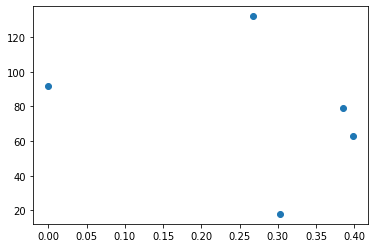

In [8]:
plt.scatter(x=df["distances"],y=df["indices"])

In [ ]:
#classics
import pandas as pd
import numpy as np
import os
# algorithm
from sklearn.neighbors import NearestNeighbors
# sparse matrix
from scipy.sparse import csr_matrix
# string matching
from fuzzywuzzy import fuzz
from Levenshtein import *
from warnings import warn


def fuzzy_matcher(mapper, favorite_movie, verbose=True):
    """
    We use fuzzy matcher to help get our ratio of movie title names that have been inputed to search through our database.
    By doing this it will return us the closest match via our fuzzy ratio, which will compare two strings and outputs our ratio.
    """
    match_tuple = []
    # geting our match
    for title, index in mapper.items():
        ratio = fuzz.ratio(title.lower(), favorite_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, index, ratio))
    # sorting
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Uh-Oh! Something went wrong on our end, please resubmit entry')
        return
    if verbose:
        print('Top ten similar matches: {0}\n'.format(
            [x[0] for x in match_tuple]))
    return match_tuple[0][1]

def recommendation(model_knn, data, mapper, favorite_movie, n_recommendations):
    # fit
    model_knn.fit(data)
    # get our movie index
    print('Film input', favorite_movie)
    index = fuzzy_matcher(mapper, favorite_movie, verbose=True)
    print('Popular recommendations:')
    print('…..\n')
    distances, indices = model_knn.kneighbors(data[index], n_neighbors=n_recommendations+1)
    raw_recommends = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # reverse mapping and unflattening
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Here are more movies similar {}:'.format(favorite_movie))
    for i, (index, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[index], dist))

In [27]:
recommendation(model_knn,combined,"48 Hrs.",5)

TypeError: recommendation() missing 1 required positional argument: 'n_recommendations'

In [26]:
combined

userId,2,3,4,5,6,7,8,9,10,11,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
"20,000 Leagues Under the Sea",0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001: A Space Odyssey,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
48 Hrs.,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,3.0,0.0
5 Card Stud,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,...,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0
A Clockwork Orange,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Waiter,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
Who Killed Bambi?,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Will Penny,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
